
#### Mapping Stations to the NYC city map
  
As of this point, we should have a list of the most visited stations, and we want to narrow this list down so that we can focus our efforts on specific stations that will most prominently feature individuals who would be interested in a Women in Tech gala.



In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt
import geopandas as gpd
import descartes
import contextily as ctx
import datetime
import dateutil
from shapely.geometry import Point, Polygon
%matplotlib inline

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 25)
pd.set_option('display.precision', 3)

In [ ]:
# df = pd.read_csv('http://web.mta.info/developers/data/nyct/turnstile/turnstile_190427.txt')

# df.columns = df.columns.str.strip()

# df.head()

# create a dictionary using the first four columns as a key
# d = df.set_index(['C/A','UNIT','SCP','STATION'])['LINENAME','DIVISION','DATE','TIME','DESC','ENTRIES','EXITS'].to_dict()

In [ ]:
#station_vals = ['C/A', 'UNIT', 'STATION', 'SCP']

#df2 = df.groupby(station_vals).sum()

#df2

Below, we take in csv files containing the locations of various colleges and universities, as well as subway station locations. They will be converted into dataframes where we have names, latitudes and longitudes.

In [2]:
cu_df = pd.read_csv('COLLEGE_UNIVERSITY.csv')

cu_df.head()

,the_geom,NAME,HOUSENUM,STREETNAME,CITY,ZIP,URL,BIN,BBL
0,POINT (-73.99465215457163 40.73519616365903),New School University / Parsons School Of Design,66,FIFTH AVENUE,New York,10011,http://www.parsons.edu/html/splash.html,1009619,1.006e+09
1,POINT (-73.99706966379965 40.73546280987431),New School University / The New School,66,WEST 12 STREET,New York,10011,http://www.newschool.edu/,1083136,1.006e+09
2,POINT (-74.00681944352681 40.723441859057495),Metropolitan College,75,VARICK STREET,New York,10013,http://www.metropolitan.edu/,1002934,1.002e+09
3,POINT (-73.79439300079635 40.73944287003665),School Of Nursing Of St. Vincents Catholic Med...,175-05,HORACE HARDING EXPRESSWAY,Fresh Meadows,11365,http://www.svcmc.org/portal/training/allied_he...,4148794,4.069e+09
4,POINT (-73.84872054010768 40.721371886956774),Bramson Ort College,69-30,AUSTIN STREET,Forest Hills,11375,http://www.bramsonort.org/,4077468,4.032e+09


In [3]:
cu_df['the_geom'] = cu_df['the_geom'].str.lstrip('POINT')
cu_df['the_geom'] = cu_df['the_geom'].str.strip()
cu_df['the_geom'] = cu_df['the_geom'].str.lstrip('(')
cu_df['the_geom'] = cu_df['the_geom'].str.rstrip(')')

new = cu_df['the_geom'].str.split(' ', n = 1, expand=True)

cu_df['Latitude'] = new[0]
cu_df['Longitude'] = new[1]

cu_df.drop(columns=['URL','BIN', 'BBL', 'the_geom', 'HOUSENUM','STREETNAME','CITY','ZIP'], inplace=True)
cu_df.head()

,NAME,Latitude,Longitude
0,New School University / Parsons School Of Design,-73.99465215457163,40.73519616365903
1,New School University / The New School,-73.99706966379965,40.73546280987431
2,Metropolitan College,-74.00681944352681,40.723441859057495
3,School Of Nursing Of St. Vincents Catholic Med...,-73.79439300079635,40.73944287003665
4,Bramson Ort College,-73.84872054010768,40.721371886956774


In [4]:
station_df = pd.read_csv('DOITT_SUBWAY_STATION_01_13SEPT2010.csv')

In [5]:
station_df['the_geom'] = station_df['the_geom'].str.lstrip('POINT')
station_df['the_geom'] = station_df['the_geom'].str.strip()
station_df['the_geom'] = station_df['the_geom'].str.lstrip('(')
station_df['the_geom'] = station_df['the_geom'].str.rstrip(')')

new = station_df['the_geom'].str.split(' ', n = 1, expand=True)

station_df['Latitude'] = new[0]
station_df['Longitude'] = new[1]

station_df.drop(columns=['URL','NOTES', 'OBJECTID', 'the_geom'], inplace=True)
station_df.head()

,NAME,LINE,Latitude,Longitude
0,Astor Pl,4-6-6 Express,-73.99106999861966,40.73005400028978
1,Canal St,4-6-6 Express,-74.00019299927328,40.71880300107709
2,50th St,1-2,-73.98384899986625,40.76172799961419
3,Bergen St,2-3-4,-73.97499915116808,40.68086213682956
4,Pennsylvania Ave,3-4,-73.89488591154061,40.66471445143568


In [6]:
# Need to convert to floats in order to work with them in geopandas
cu_df['Latitude'] = cu_df['Latitude'].astype(float)
cu_df['Longitude'] = cu_df['Longitude'].astype(float)

station_df['Latitude'] = station_df['Latitude'].astype(float)
station_df['Longitude'] = station_df['Longitude'].astype(float)

Now that we have latitude and longitude data for both sets, we are going to import a street map and utilize geopandas to plot it.

In [ ]:
# streetmap = gpd.read_file('Borough Boundaries/geo_export_e4d22ac3-833c-4d50-8086-f7420a1d1ef4.shp')

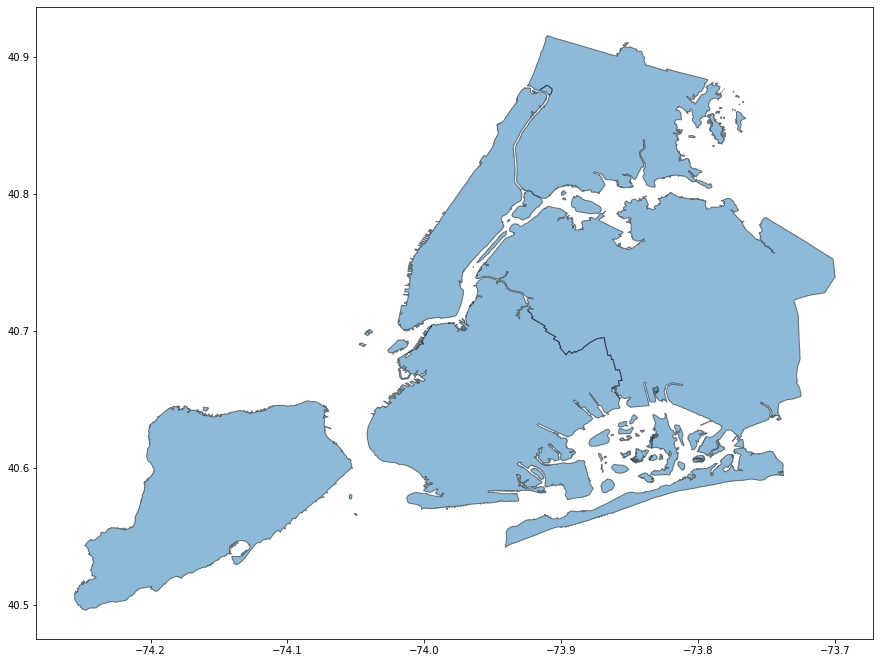

In [7]:
# fig, ax = plt.pyplot.subplots(figsize=(15,15))
# streetmap.plot(ax = ax);

streetmap = gpd.read_file(gpd.datasets.get_path('nybb'))
streetmap = streetmap.to_crs(epsg=4326)
ax = streetmap.plot(figsize=(15, 15), alpha=0.5, edgecolor='k')

We need to convert our latitudes and longitudes into usable points, and we need to specify a coordinate reference system (in this case the latitude/longitude projection system)

In [8]:
geometry_stations = [Point(xy) for xy in zip(station_df['Longitude'],station_df['Latitude'])]
crs = {'init': 'epsg:4326'}

In [9]:
geo_df = gpd.GeoDataFrame(station_df, crs=crs, geometry=geometry_stations)
geo_df.head()

,NAME,LINE,Latitude,Longitude,geometry
0,Astor Pl,4-6-6 Express,-73.991,40.730,POINT (40.73005400028978 -73.99106999861966)
1,Canal St,4-6-6 Express,-74.000,40.719,POINT (40.71880300107709 -74.00019299927328)
2,50th St,1-2,-73.984,40.762,POINT (40.76172799961419 -73.98384899986625)
3,Bergen St,2-3-4,-73.975,40.681,POINT (40.68086213682956 -73.97499915116808)
4,Pennsylvania Ave,3-4,-73.895,40.665,POINT (40.66471445143568 -73.89488591154061)


In [15]:
def add_basemap(ax, zoom, url='http://tile.stamen.com/terrain/tileZ/tileX/tileY.png'):
    xmin, xmax, ymin, ymax = ax.axis()
    basemap, extent = ctx.bounds2img(xmin, ymin, xmax, ymax, zoom=zoom, url=url)
    ax.imshow(basemap, extent=extent, interpolation='bilinear')
    # restore original x/y limits
    ax.axis((xmin, xmax, ymin, ymax))

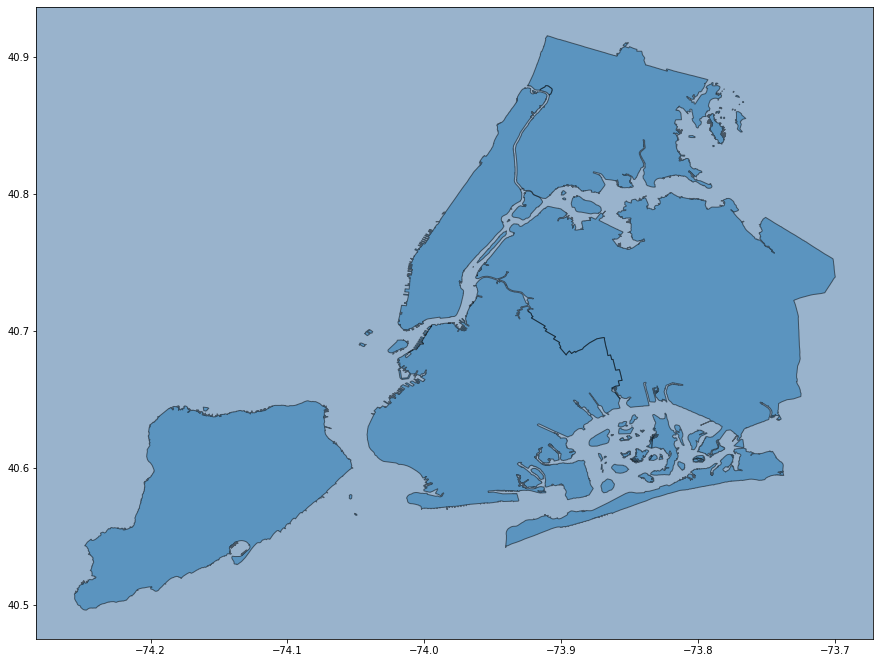

In [21]:
# fig, ax = plt.pyplot.subplots(figsize=(15,15))
# minx, miny, maxx, maxy = geo_df.total_bounds
# ax.set_xlim(minx, maxx)
# ax.set_ylim(miny, maxy)
ax = streetmap.plot(figsize=(15, 15), alpha=0.5, edgecolor='k')
add_basemap(ax, zoom=10)
# streetmap.plot(ax=ax, color='black');
#geo_df.plot(ax=ax,color='red');
